In [1]:
!pip install colossalai

In [2]:
import os
from pathlib import Path
import math
import colossalai
import torch
import torch.nn as nn
import torch.nn.functional as F
from colossalai.core import global_context as gpc
from colossalai.logging import get_dist_logger
from colossalai.nn import CosineAnnealingLR
from colossalai.nn.metric import Accuracy
from colossalai.trainer import Trainer, hooks
from colossalai.utils import MultiTimer, get_dataloader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
torch.__version__

'1.10.0+cu111'

In [4]:
colossalai.__version__

'0.0.1'

In [5]:
torch.cuda.is_available()

True

In [6]:


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits


config = {'BATCH_SIZE':128,'NUM_EPOCHS':30}

colossalai.launch(config=config,rank=0,world_size=1,host='127.0.0.1',port=1234)

logger = get_dist_logger()



[04/01/22 14:11:16] INFO     colossalai -                             ]8;id=254472;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=176884;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,336 INFO: Added key:                        
                             store_based_barrier_key:1 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=981859;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=54031;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,347 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:1 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=803440;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=291676;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,354 INFO: Added key:                        
                             store_based_barrier_key:2 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=342695;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=314348;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,362 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:2 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=583405;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=783574;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,367 INFO: Added key:                        
                             store_based_barrier_key:3 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=836343;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=513657;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,376 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:3 with 1                            
                             nodes.                                                          

                    INFO     colossalai -                             ]8;id=291654;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=167602;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#217\217]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,384 INFO: Added key:                        
                             store_based_barrier_key:4 to store for                          
                             rank: 0                                                         

                    INFO     colossalai -                             ]8;id=405425;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py\distributed_c10d.py]8;;\:]8;id=923928;file:///usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py#252\252]8;;\
                             torch.distributed.distributed_c10d -                            
                             2022-04-01 14:11:16,391 INFO: Rank 0:                           
                             Completed store-based barrier for                               
                             key:store_based_barrier_key:4 with 1                            
                             nodes.                                                          

                    INFO     colossalai - colossalai - 2022-04-01 14:11:16,398  ]8;id=336074;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=838486;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: process rank 0 is bound to device 0                       

                    INFO     colossalai - colossalai - 2022-04-01 14:11:16,411  ]8;id=835769;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=20063;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: initialized seed on rank 0, numpy: 1024,                  
                             python random: 1024, ParallelMode.DATA: 1024,                   
                             ParallelMode.TENSOR: 1024,the default parallel                  
                             seed is ParallelMode.DATA.                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:11:16,426  ]8;id=506985;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=408344;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Distributed environment is initialized, data              
                             parallel size: 1, pipeline parallel size: 1,                    
                             tensor parallel size: 1                                         

In [7]:

# build 

model = LeNet5(n_classes=10)

# build dataloaders
train_dataset = MNIST(
    root=Path('./tmp/'),
    download=True,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

test_dataset = MNIST(
    root=Path('./tmp/'),
    train=False,
    transform = transforms.Compose([transforms.Resize((32, 32)),
                              transforms.ToTensor()])
)

train_dataloader = get_dataloader(dataset=train_dataset,
                                  shuffle=True,
                                  batch_size=gpc.config.BATCH_SIZE,
                                  num_workers=1,
                                  pin_memory=True,
                                  )

test_dataloader = get_dataloader(dataset=test_dataset,
                                  add_sampler=False,
                                  batch_size=gpc.config.BATCH_SIZE,
                                  num_workers=1,
                                  pin_memory=True,
                                  )

# build criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

#exponentially increase learning rate from low to high
def lrs(batch):
    low = math.log2(1e-5)
    high = math.log2(10)
    return 2**(low+(high-low)*batch/len(train_dataloader)/gpc.config.NUM_EPOCHS)




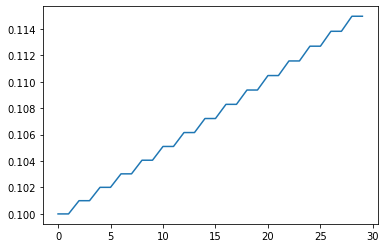

In [8]:
# lr_scheduler, lambda or onecycle
#lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lrs)
#lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=2*(len(train_dataloader)), epochs=30)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=1.01)

lrs = []
for i in range(30):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

plt.plot(range(30),lrs)

In [9]:

engine, train_dataloader, test_dataloader, _ = colossalai.initialize(model,
                                        optimizer,
                                        criterion,
                                        train_dataloader,
                                        test_dataloader,
                                        )
# build a timer to measure time
timer = MultiTimer()

# create a trainer object
trainer = Trainer(
    engine=engine,
    timer=timer,
    logger=logger
)

# define the hooks to attach to the trainer
hook_list = [
    hooks.LossHook(),
    hooks.LRSchedulerHook(lr_scheduler=lr_scheduler, by_epoch=False),
    # hooks.AccuracyHook(accuracy_func=Accuracy()),
    hooks.LogMetricByEpochHook(logger),
    hooks.LogMemoryByEpochHook(logger),
    hooks.LogTimingByEpochHook(timer, logger),

    # you can uncomment these lines if you wish to use them
    hooks.TensorboardHook(log_dir='./tb_logs', ranks=[0]),
    # hooks.SaveCheckpointHook(checkpoint_dir='./ckpt')
]

# start training
trainer.fit(
    train_dataloader=train_dataloader,
    epochs=gpc.config.NUM_EPOCHS,
    test_dataloader=test_dataloader,
    test_interval=1,
    hooks=hook_list,
    display_progress=True
)

                    INFO     colossalai - colossalai - 2022-04-01 14:11:16,884  ]8;id=338916;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=869699;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO:                                                           
                             ========== Your Config ========                                 
                             {'BATCH_SIZE': 128, 'NUM_EPOCHS': 30}                           
                             ================================                                
                                                                                             

                    INFO     colossalai - colossalai - 2022-04-01 14:11:16,896  ]8;id=831130;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=912715;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: cuDNN benchmark = True, deterministic =                   
                             False                                                           

[04/01/22 14:11:19] WARNING  colossalai - colossalai - 2022-04-01 14:11:19,804  ]8;id=545030;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=105313;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             WARNING: Initializing an non ZeRO model with                    
                             optimizer class                                                 

                    WARNING  colossalai - colossalai - 2022-04-01 14:11:19,809  ]8;id=466742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=537792;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             WARNING: No PyTorch DDP or gradient handler is set              
                             up, please make sure you do not need to all-reduce              
                             the gradients after a training step.                            

[04/01/22 14:11:25] INFO     colossalai - colossalai - 2022-04-01 14:11:25,491  ]8;id=383671;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=847219;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LossHook for training, priority = 0                 

                    INFO     colossalai - colossalai - 2022-04-01 14:11:25,499  ]8;id=756882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=846255;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LRSchedulerHook for training, priority              
                             = 1                                                             

                    INFO     colossalai - colossalai - 2022-04-01 14:11:25,513  ]8;id=750747;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=386742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogMetricByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 14:11:25,522  ]8;id=407266;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=832621;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogMemoryByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 14:11:25,534  ]8;id=100681;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=745997;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using LogTimingByEpochHook for training,                  
                             priority = 10                                                   

                    INFO     colossalai - colossalai - 2022-04-01 14:11:25,542  ]8;id=781049;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=916139;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Using TensorboardHook for training, priority              
                             = 10                                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:11:25,551  ]8;id=146962;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=836397;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#113\113]8;;\
                             INFO: Lower value means higher priority for                     
                             calling hook function                                           

[04/01/22 14:11:26] INFO     colossalai - colossalai - 2022-04-01 14:11:26,567  ]8;id=408446;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=107259;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: Before-train: GPU: allocated 0.24 MB, max                 
                             allocated 0.24 MB, cached: 2.0 MB, max cached: 2.0              
                             MB                                                              

[Epoch 0 / Train]: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]


[04/01/22 14:11:48] INFO     colossalai - colossalai - 2022-04-01 14:11:48,150  ]8;id=429527;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=162597;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: Loss = 0.49546 | LR =                  
                             1.1913                                                          

                    INFO     colossalai - colossalai - 2022-04-01 14:11:48,161  ]8;id=457398;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=496973;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 88.39 MB, cached: 26.0 MB, max                    
                             cached: 108.0 MB                                                

                    INFO     colossalai - colossalai - 2022-04-01 14:11:48,171  ]8;id=467890;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=770472;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Train]: Train-epoch: last = 21.29              
                             s, mean = 21.29 s | Train-step: last = 0.084694 s,              
                             mean = 0.041687 s | #steps/epoch = 469                          

[Epoch 0 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.35it/s]


[04/01/22 14:11:50] INFO     colossalai - colossalai - 2022-04-01 14:11:50,981  ]8;id=550437;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=884148;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: Loss = 5.4468                           

                    INFO     colossalai - colossalai - 2022-04-01 14:11:50,996  ]8;id=966525;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=364022;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: Test-epoch: last = 2.6997               
                             s, mean = 2.6997 s | Test-step: last = 0.022482 s,              
                             mean = 0.031194 s                                               

[04/01/22 14:11:51] INFO     colossalai - colossalai - 2022-04-01 14:11:51,012  ]8;id=646487;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=947990;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 0 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 17.82 MB, cached: 24.0 MB, max                    
                             cached: 26.0 MB                                                 

[Epoch 1 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]


[04/01/22 14:12:08] INFO     colossalai - colossalai - 2022-04-01 14:12:08,665  ]8;id=637420;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=92566;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: Loss = 538.26 | LR =                   
                             12.347                                                          

                    INFO     colossalai - colossalai - 2022-04-01 14:12:08,676  ]8;id=36874;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=87591;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:12:08,689  ]8;id=667345;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=807369;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Train]: Train-epoch: last =                    
                             17.526 s, mean = 17.526 s | Train-step: last =                  
                             0.02013 s, mean = 0.037494 s | #steps/epoch = 469               

[Epoch 1 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.76it/s]


[04/01/22 14:12:11] INFO     colossalai - colossalai - 2022-04-01 14:12:11,456  ]8;id=86073;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=107367;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: Loss = 1818.7                           

                    INFO     colossalai - colossalai - 2022-04-01 14:12:11,465  ]8;id=379642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=722727;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: Test-epoch: last = 2.6601               
                             s, mean = 2.6601 s | Test-step: last = 0.0025144                
                             s, mean = 0.030756 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:12:11,479  ]8;id=350587;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=914387;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 1 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 2 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]


[04/01/22 14:12:29] INFO     colossalai - colossalai - 2022-04-01 14:12:29,195  ]8;id=3561;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=388801;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: Loss = 3841.8 | LR =                   
                             126.69                                                          

                    INFO     colossalai - colossalai - 2022-04-01 14:12:29,204  ]8;id=971517;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=315445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:12:29,215  ]8;id=191330;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=141390;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Train]: Train-epoch: last =                    
                             17.585 s, mean = 17.585 s | Train-step: last =                  
                             0.022118 s, mean = 0.036251 s | #steps/epoch = 469              

[Epoch 2 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.65it/s]


[04/01/22 14:12:31] INFO     colossalai - colossalai - 2022-04-01 14:12:31,961  ]8;id=167384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=959325;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: Loss = 9333.8                           

                    INFO     colossalai - colossalai - 2022-04-01 14:12:31,969  ]8;id=408057;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=299722;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: Test-epoch: last = 2.6678               
                             s, mean = 2.6678 s | Test-step: last = 0.0035381                
                             s, mean = 0.030751 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:12:31,980  ]8;id=168896;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=907314;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 2 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 9.8 MB, cached: 50.0 MB, max cached:              
                             50.0 MB                                                         

[Epoch 3 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]


[04/01/22 14:12:49] INFO     colossalai - colossalai - 2022-04-01 14:12:49,858  ]8;id=95277;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=240130;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: Loss = 17529 | LR = 1313               

                    INFO     colossalai - colossalai - 2022-04-01 14:12:49,880  ]8;id=860176;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=610902;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:12:49,887  ]8;id=126868;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=481816;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Train]: Train-epoch: last =                    
                             17.738 s, mean = 17.738 s | Train-step: last =                  
                             0.026559 s, mean = 0.035631 s | #steps/epoch = 469              

[Epoch 3 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.80it/s]


[04/01/22 14:12:52] INFO     colossalai - colossalai - 2022-04-01 14:12:52,754  ]8;id=714915;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=949050;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: Loss = 43779                            

                    INFO     colossalai - colossalai - 2022-04-01 14:12:52,763  ]8;id=588986;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=24862;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: Test-epoch: last = 2.7438               
                             s, mean = 2.7438 s | Test-step: last = 0.0029285                
                             s, mean = 0.031371 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:12:52,783  ]8;id=731619;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=430394;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 3 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 4 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.05it/s]


[04/01/22 14:13:11] INFO     colossalai - colossalai - 2022-04-01 14:13:11,627  ]8;id=845059;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=22590;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: Loss = nan | LR = 13473                

                    INFO     colossalai - colossalai - 2022-04-01 14:13:11,636  ]8;id=867384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=22492;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:13:11,649  ]8;id=954487;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=920788;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Train]: Train-epoch: last =                    
                             18.726 s, mean = 18.726 s | Train-step: last =                  
                             0.018651 s, mean = 0.035609 s | #steps/epoch = 469              

[Epoch 4 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.21it/s]


[04/01/22 14:13:14] INFO     colossalai - colossalai - 2022-04-01 14:13:14,469  ]8;id=258997;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=788654;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: Loss = nan                              

                    INFO     colossalai - colossalai - 2022-04-01 14:13:14,479  ]8;id=942760;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=868513;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: Test-epoch: last = 2.7052               
                             s, mean = 2.7052 s | Test-step: last = 0.0017574                
                             s, mean = 0.031251 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:13:14,500  ]8;id=162409;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=984032;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 4 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 5 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.52it/s]


[04/01/22 14:13:32] INFO     colossalai - colossalai - 2022-04-01 14:13:32,313  ]8;id=349879;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=360737;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Train]: Loss = nan | LR =                      
                             1.3963e+05                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:13:32,330  ]8;id=483769;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=918446;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:13:32,343  ]8;id=640060;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=182619;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Train]: Train-epoch: last =                    
                             17.681 s, mean = 17.681 s | Train-step: last =                  
                             0.020905 s, mean = 0.035248 s | #steps/epoch = 469              

[Epoch 5 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.67it/s]


[04/01/22 14:13:35] INFO     colossalai - colossalai - 2022-04-01 14:13:35,127  ]8;id=576041;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=725206;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Test]: Loss = nan                              

                    INFO     colossalai - colossalai - 2022-04-01 14:13:35,144  ]8;id=836666;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=836662;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Test]: Test-epoch: last = 2.6672               
                             s, mean = 2.6672 s | Test-step: last = 0.0016806                
                             s, mean = 0.030808 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:13:35,157  ]8;id=446925;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=63825;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 5 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 6 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]


[04/01/22 14:13:53] INFO     colossalai - colossalai - 2022-04-01 14:13:53,063  ]8;id=70331;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=977182;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Train]: Loss = nan | LR =                      
                             1.4328e+06                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:13:53,074  ]8;id=863207;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=402177;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:13:53,086  ]8;id=905861;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=103165;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Train]: Train-epoch: last =                    
                             17.769 s, mean = 17.769 s | Train-step: last =                  
                             0.015547 s, mean = 0.035002 s | #steps/epoch = 469              

[Epoch 6 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.20it/s]


[04/01/22 14:13:56] INFO     colossalai - colossalai - 2022-04-01 14:13:56,021  ]8;id=762359;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=625377;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Test]: Loss = nan                              

                    INFO     colossalai - colossalai - 2022-04-01 14:13:56,029  ]8;id=407888;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=196577;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Test]: Test-epoch: last = 2.8016               
                             s, mean = 2.8016 s | Test-step: last = 0.0036881                
                             s, mean = 0.032032 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:13:56,041  ]8;id=993663;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=224728;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 6 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 7 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]


[04/01/22 14:14:14] INFO     colossalai - colossalai - 2022-04-01 14:14:14,272  ]8;id=910994;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=739940;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Train]: Loss = nan | LR =                      
                             1.485e+07                                                       

                    INFO     colossalai - colossalai - 2022-04-01 14:14:14,281  ]8;id=36037;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=196456;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:14:14,291  ]8;id=647959;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=839321;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Train]: Train-epoch: last =                    
                             18.101 s, mean = 18.101 s | Train-step: last =                  
                             0.018137 s, mean = 0.034936 s | #steps/epoch = 469              

[Epoch 7 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s]


[04/01/22 14:14:17] INFO     colossalai - colossalai - 2022-04-01 14:14:17,228  ]8;id=689212;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=346241;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Test]: Loss = nan                              

                    INFO     colossalai - colossalai - 2022-04-01 14:14:17,238  ]8;id=315626;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=896682;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Test]: Test-epoch: last = 2.8149               
                             s, mean = 2.8149 s | Test-step: last = 0.007216 s,              
                             mean = 0.03276 s                                                

                    INFO     colossalai - colossalai - 2022-04-01 14:14:17,255  ]8;id=430282;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=487412;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 7 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 8 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.46it/s]


[04/01/22 14:14:35] INFO     colossalai - colossalai - 2022-04-01 14:14:35,119  ]8;id=540872;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=86111;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Train]: Loss = nan | LR =                      
                             1.5238e+08                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:14:35,129  ]8;id=885700;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=651837;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:14:35,136  ]8;id=380113;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=99476;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Train]: Train-epoch: last =                    
                             17.734 s, mean = 17.734 s | Train-step: last =                  
                             0.020623 s, mean = 0.034818 s | #steps/epoch = 469              

[Epoch 8 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.32it/s]


[04/01/22 14:14:38] INFO     colossalai - colossalai - 2022-04-01 14:14:38,053  ]8;id=269089;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=950520;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Test]: Loss = nan                              

                    INFO     colossalai - colossalai - 2022-04-01 14:14:38,061  ]8;id=867853;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=40055;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Test]: Test-epoch: last = 2.7933               
                             s, mean = 2.7933 s | Test-step: last = 0.010182 s,              
                             mean = 0.031919 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 14:14:38,076  ]8;id=834109;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=73024;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 8 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 9 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.38it/s]


[04/01/22 14:14:55] INFO     colossalai - colossalai - 2022-04-01 14:14:55,979  ]8;id=804116;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=883542;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Train]: Loss = nan | LR =                      
                             1.5792e+09                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:14:55,994  ]8;id=833281;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=625996;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Train]: GPU: allocated 4.71 MB,                
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

[04/01/22 14:14:56] INFO     colossalai - colossalai - 2022-04-01 14:14:56,005  ]8;id=191183;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=131617;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Train]: Train-epoch: last =                    
                             17.777 s, mean = 17.777 s | Train-step: last =                  
                             0.019932 s, mean = 0.034659 s | #steps/epoch = 469              

[Epoch 9 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.36it/s]


[04/01/22 14:14:58] INFO     colossalai - colossalai - 2022-04-01 14:14:58,825  ]8;id=555129;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=509092;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Test]: Loss = nan                              

                    INFO     colossalai - colossalai - 2022-04-01 14:14:58,833  ]8;id=840360;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=889445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Test]: Test-epoch: last = 2.6951               
                             s, mean = 2.6951 s | Test-step: last = 0.0051403                
                             s, mean = 0.031207 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:14:58,843  ]8;id=339508;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=444856;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 9 / Test]: GPU: allocated 0.72 MB,                 
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 10 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]


[04/01/22 14:15:16] INFO     colossalai - colossalai - 2022-04-01 14:15:16,865  ]8;id=483450;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=370817;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Train]: Loss = nan | LR =                     
                             1.6205e+10                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:15:16,874  ]8;id=81688;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=608882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.86 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:15:16,881  ]8;id=931364;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=516241;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Train]: Train-epoch: last =                   
                             17.886 s, mean = 17.886 s | Train-step: last =                  
                             0.020411 s, mean = 0.034571 s | #steps/epoch = 469              

[Epoch 10 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.36it/s]


[04/01/22 14:15:19] INFO     colossalai - colossalai - 2022-04-01 14:15:19,799  ]8;id=816145;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=376110;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:15:19,809  ]8;id=938469;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=564944;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Test]: Test-epoch: last = 2.7838              
                             s, mean = 2.7838 s | Test-step: last = 0.0032971                
                             s, mean = 0.032402 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:15:19,826  ]8;id=859628;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=179601;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 10 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 11 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.97it/s]


[04/01/22 14:15:38] INFO     colossalai - colossalai - 2022-04-01 14:15:38,025  ]8;id=99617;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=878042;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Train]: Loss = nan | LR =                     
                             1.6794e+11                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:15:38,036  ]8;id=257087;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=533695;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:15:38,048  ]8;id=579674;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=808029;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Train]: Train-epoch: last =                   
                             18.07 s, mean = 18.07 s | Train-step: last =                    
                             0.021292 s, mean = 0.034542 s | #steps/epoch = 469              

[Epoch 11 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.14it/s]


[04/01/22 14:15:40] INFO     colossalai - colossalai - 2022-04-01 14:15:40,978  ]8;id=680352;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=440507;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:15:40,988  ]8;id=689603;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=907384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Test]: Test-epoch: last = 2.8089              
                             s, mean = 2.8089 s | Test-step: last = 0.010973 s,              
                             mean = 0.03234 s                                                

[04/01/22 14:15:41] INFO     colossalai - colossalai - 2022-04-01 14:15:41,008  ]8;id=535475;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=989805;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 11 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 12 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.89it/s]


[04/01/22 14:15:59] INFO     colossalai - colossalai - 2022-04-01 14:15:59,251  ]8;id=517001;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=687062;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Train]: Loss = nan | LR =                     
                             1.7233e+12                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:15:59,267  ]8;id=142056;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=9133;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:15:59,277  ]8;id=232386;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=324486;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Train]: Train-epoch: last =                   
                             18.115 s, mean = 18.115 s | Train-step: last =                  
                             0.019882 s, mean = 0.034577 s | #steps/epoch = 469              

[Epoch 12 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.52it/s]


[04/01/22 14:16:02] INFO     colossalai - colossalai - 2022-04-01 14:16:02,168  ]8;id=392177;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=793733;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:16:02,183  ]8;id=156200;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=747721;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Test]: Test-epoch: last = 2.7685              
                             s, mean = 2.7685 s | Test-step: last = 0.0028501                
                             s, mean = 0.03298 s                                             

                    INFO     colossalai - colossalai - 2022-04-01 14:16:02,197  ]8;id=587338;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=214751;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 12 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 13 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]


[04/01/22 14:16:20] INFO     colossalai - colossalai - 2022-04-01 14:16:20,579  ]8;id=113001;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=839476;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Train]: Loss = nan | LR =                     
                             1.786e+13                                                       

                    INFO     colossalai - colossalai - 2022-04-01 14:16:20,590  ]8;id=356370;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=268316;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:16:20,603  ]8;id=297753;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=500786;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Train]: Train-epoch: last =                   
                             18.255 s, mean = 18.255 s | Train-step: last =                  
                             0.017772 s, mean = 0.034596 s | #steps/epoch = 469              

[Epoch 13 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]


[04/01/22 14:16:23] INFO     colossalai - colossalai - 2022-04-01 14:16:23,593  ]8;id=27346;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=938029;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:16:23,606  ]8;id=753229;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=352831;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Test]: Test-epoch: last = 2.8459              
                             s, mean = 2.8459 s | Test-step: last = 0.0032232                
                             s, mean = 0.033038 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:16:23,622  ]8;id=29495;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=575821;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 13 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 14 / Train]: 100%|██████████| 469/469 [00:18<00:00, 26.04it/s]


[04/01/22 14:16:41] INFO     colossalai - colossalai - 2022-04-01 14:16:41,772  ]8;id=401774;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=148601;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Train]: Loss = nan | LR =                     
                             1.8327e+14                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:16:41,793  ]8;id=257361;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=475057;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:16:41,810  ]8;id=783296;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=224946;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Train]: Train-epoch: last =                   
                             18.01 s, mean = 18.01 s | Train-step: last =                    
                             0.021034 s, mean = 0.034565 s | #steps/epoch = 469              

[Epoch 14 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.66it/s]


[04/01/22 14:16:44] INFO     colossalai - colossalai - 2022-04-01 14:16:44,701  ]8;id=101382;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=150642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:16:44,710  ]8;id=770826;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=165725;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Test]: Test-epoch: last = 2.757               
                             s, mean = 2.757 s | Test-step: last = 0.0027182 s,              
                             mean = 0.031621 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 14:16:44,728  ]8;id=855307;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=857287;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 14 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 15 / Train]: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]


[04/01/22 14:17:02] INFO     colossalai - colossalai - 2022-04-01 14:17:02,812  ]8;id=65931;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=569325;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Train]: Loss = nan | LR =                     
                             1.8994e+15                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:17:02,822  ]8;id=606737;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=683415;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:17:02,838  ]8;id=6028;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=620072;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Train]: Train-epoch: last =                   
                             17.952 s, mean = 17.952 s | Train-step: last =                  
                             0.02079 s, mean = 0.034526 s | #steps/epoch = 469               

[Epoch 15 / Test]: 100%|██████████| 79/79 [00:02<00:00, 29.76it/s]


[04/01/22 14:17:05] INFO     colossalai - colossalai - 2022-04-01 14:17:05,631  ]8;id=663422;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=349819;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:17:05,643  ]8;id=380583;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=511566;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Test]: Test-epoch: last = 2.6591              
                             s, mean = 2.6591 s | Test-step: last = 0.00278 s,               
                             mean = 0.030604 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 14:17:05,654  ]8;id=657372;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=120994;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 15 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 16 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]


[04/01/22 14:17:23] INFO     colossalai - colossalai - 2022-04-01 14:17:23,834  ]8;id=218372;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=414376;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Train]: Loss = nan | LR =                     
                             1.949e+16                                                       

                    INFO     colossalai - colossalai - 2022-04-01 14:17:23,850  ]8;id=943510;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=474550;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:17:23,858  ]8;id=71543;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=874578;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Train]: Train-epoch: last =                   
                             18.048 s, mean = 18.048 s | Train-step: last =                  
                             0.020814 s, mean = 0.034521 s | #steps/epoch = 469              

[Epoch 16 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.49it/s]


[04/01/22 14:17:26] INFO     colossalai - colossalai - 2022-04-01 14:17:26,872  ]8;id=676592;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=229332;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:17:26,881  ]8;id=661882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=510875;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Test]: Test-epoch: last = 2.868               
                             s, mean = 2.868 s | Test-step: last = 0.003283 s,               
                             mean = 0.032796 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 14:17:26,896  ]8;id=791561;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=263959;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 16 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 17 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.40it/s]


[04/01/22 14:17:45] INFO     colossalai - colossalai - 2022-04-01 14:17:45,502  ]8;id=705153;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=352256;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Train]: Loss = nan | LR =                     
                             2.0199e+17                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:17:45,516  ]8;id=492186;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=492064;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:17:45,526  ]8;id=915103;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=279860;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Train]: Train-epoch: last =                   
                             18.466 s, mean = 18.466 s | Train-step: last =                  
                             0.023539 s, mean = 0.034545 s | #steps/epoch = 469              

[Epoch 17 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.83it/s]


[04/01/22 14:17:48] INFO     colossalai - colossalai - 2022-04-01 14:17:48,496  ]8;id=746685;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=639927;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:17:48,505  ]8;id=452620;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=984059;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Test]: Test-epoch: last = 2.8409              
                             s, mean = 2.8409 s | Test-step: last = 0.010466 s,              
                             mean = 0.03253 s                                                

                    INFO     colossalai - colossalai - 2022-04-01 14:17:48,516  ]8;id=685514;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=207747;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 17 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 18 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]


[04/01/22 14:18:06] INFO     colossalai - colossalai - 2022-04-01 14:18:06,997  ]8;id=786159;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=20444;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Train]: Loss = nan | LR =                     
                             2.0727e+18                                                      

[04/01/22 14:18:07] INFO     colossalai - colossalai - 2022-04-01 14:18:07,013  ]8;id=426405;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=454232;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:18:07,025  ]8;id=289788;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=937853;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Train]: Train-epoch: last =                   
                             18.343 s, mean = 18.343 s | Train-step: last =                  
                             0.02985 s, mean = 0.034578 s | #steps/epoch = 469               

[Epoch 18 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


[04/01/22 14:18:09] INFO     colossalai - colossalai - 2022-04-01 14:18:09,971  ]8;id=125318;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=859781;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:18:09,980  ]8;id=329641;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=359825;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Test]: Test-epoch: last = 2.805               
                             s, mean = 2.805 s | Test-step: last = 0.0073318 s,              
                             mean = 0.031938 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 14:18:09,990  ]8;id=433510;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=368417;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 18 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 19 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.37it/s]


[04/01/22 14:18:28] INFO     colossalai - colossalai - 2022-04-01 14:18:28,629  ]8;id=510608;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=554445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Train]: Loss = nan | LR =                     
                             2.1481e+19                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:18:28,648  ]8;id=631642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=15282;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:18:28,657  ]8;id=530678;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=135642;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Train]: Train-epoch: last =                   
                             18.488 s, mean = 18.488 s | Train-step: last =                  
                             0.027334 s, mean = 0.034616 s | #steps/epoch = 469              

[Epoch 19 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.87it/s]


[04/01/22 14:18:31] INFO     colossalai - colossalai - 2022-04-01 14:18:31,648  ]8;id=292432;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=635248;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:18:31,661  ]8;id=41539;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=832388;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Test]: Test-epoch: last = 2.8343              
                             s, mean = 2.8343 s | Test-step: last = 0.0043347                
                             s, mean = 0.032032 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:18:31,674  ]8;id=382293;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=138209;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 19 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 20 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]


[04/01/22 14:18:50] INFO     colossalai - colossalai - 2022-04-01 14:18:50,240  ]8;id=262166;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=164813;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Train]: Loss = nan | LR =                     
                             2.2043e+20                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:18:50,260  ]8;id=133623;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=175907;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:18:50,272  ]8;id=293797;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=217589;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Train]: Train-epoch: last =                   
                             18.432 s, mean = 18.432 s | Train-step: last =                  
                             0.020065 s, mean = 0.034643 s | #steps/epoch = 469              

[Epoch 20 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


[04/01/22 14:18:53] INFO     colossalai - colossalai - 2022-04-01 14:18:53,211  ]8;id=94501;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=357927;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:18:53,223  ]8;id=445927;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=960578;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Test]: Test-epoch: last = 2.8149              
                             s, mean = 2.8149 s | Test-step: last = 0.0029104                
                             s, mean = 0.032802 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:18:53,239  ]8;id=308025;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=234439;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 20 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 21 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]


[04/01/22 14:19:11] INFO     colossalai - colossalai - 2022-04-01 14:19:11,700  ]8;id=775066;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=722656;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Train]: Loss = nan | LR =                     
                             2.2845e+21                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:19:11,711  ]8;id=80962;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=118144;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:19:11,721  ]8;id=878942;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=965990;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Train]: Train-epoch: last =                   
                             18.315 s, mean = 18.315 s | Train-step: last =                  
                             0.021434 s, mean = 0.034642 s | #steps/epoch = 469              

[Epoch 21 / Test]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s]


[04/01/22 14:19:14] INFO     colossalai - colossalai - 2022-04-01 14:19:14,663  ]8;id=547451;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=989605;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:19:14,675  ]8;id=262910;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=561788;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Test]: Test-epoch: last = 2.8172              
                             s, mean = 2.8172 s | Test-step: last = 0.0030923                
                             s, mean = 0.032701 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:19:14,690  ]8;id=324084;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=68712;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 21 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 22 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]


[04/01/22 14:19:33] INFO     colossalai - colossalai - 2022-04-01 14:19:33,290  ]8;id=892805;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=15698;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Train]: Loss = nan | LR =                     
                             2.3442e+22                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:19:33,300  ]8;id=821530;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=477500;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:19:33,322  ]8;id=423377;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=445511;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Train]: Train-epoch: last =                   
                             18.457 s, mean = 18.457 s | Train-step: last =                  
                             0.019473 s, mean = 0.034664 s | #steps/epoch = 469              

[Epoch 22 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.65it/s]


[04/01/22 14:19:36] INFO     colossalai - colossalai - 2022-04-01 14:19:36,314  ]8;id=958550;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=117615;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:19:36,327  ]8;id=142762;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=372338;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Test]: Test-epoch: last = 2.8659              
                             s, mean = 2.8659 s | Test-step: last = 0.0026336                
                             s, mean = 0.033256 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:19:36,347  ]8;id=511640;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=411711;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 22 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 23 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]


[04/01/22 14:19:54] INFO     colossalai - colossalai - 2022-04-01 14:19:54,799  ]8;id=761046;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=712337;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Train]: Loss = nan | LR =                     
                             2.4295e+23                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:19:54,812  ]8;id=8041;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=436960;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:19:54,825  ]8;id=694951;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=544327;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Train]: Train-epoch: last =                   
                             18.315 s, mean = 18.315 s | Train-step: last =                  
                             0.029403 s, mean = 0.034696 s | #steps/epoch = 469              

[Epoch 23 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.86it/s]


[04/01/22 14:19:57] INFO     colossalai - colossalai - 2022-04-01 14:19:57,801  ]8;id=619451;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=553000;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:19:57,818  ]8;id=445690;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=823309;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Test]: Test-epoch: last = 2.8409              
                             s, mean = 2.8409 s | Test-step: last = 0.0025806                
                             s, mean = 0.032081 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:19:57,828  ]8;id=746178;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=634880;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 23 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 24 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]


[04/01/22 14:20:16] INFO     colossalai - colossalai - 2022-04-01 14:20:16,421  ]8;id=552973;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=873527;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Train]: Loss = nan | LR =                     
                             2.493e+24                                                       

                    INFO     colossalai - colossalai - 2022-04-01 14:20:16,443  ]8;id=995125;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=480742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:20:16,453  ]8;id=661796;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=763684;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Train]: Train-epoch: last =                   
                             18.453 s, mean = 18.453 s | Train-step: last =                  
                             0.022665 s, mean = 0.034728 s | #steps/epoch = 469              

[Epoch 24 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.94it/s]


[04/01/22 14:20:19] INFO     colossalai - colossalai - 2022-04-01 14:20:19,428  ]8;id=435806;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=905613;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:20:19,445  ]8;id=409924;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=39513;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Test]: Test-epoch: last = 2.8308              
                             s, mean = 2.8308 s | Test-step: last = 0.0031416                
                             s, mean = 0.03215 s                                             

                    INFO     colossalai - colossalai - 2022-04-01 14:20:19,457  ]8;id=283129;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=935664;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 24 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 25 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]


[04/01/22 14:20:38] INFO     colossalai - colossalai - 2022-04-01 14:20:38,259  ]8;id=395266;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=408906;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Train]: Loss = nan | LR =                     
                             2.5837e+25                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:20:38,281  ]8;id=183734;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=734400;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:20:38,291  ]8;id=944237;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=388141;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Train]: Train-epoch: last =                   
                             18.657 s, mean = 18.657 s | Train-step: last =                  
                             0.022074 s, mean = 0.034778 s | #steps/epoch = 469              

[Epoch 25 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.60it/s]


[04/01/22 14:20:41] INFO     colossalai - colossalai - 2022-04-01 14:20:41,300  ]8;id=436592;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=207045;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:20:41,313  ]8;id=788232;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=242588;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Test]: Test-epoch: last = 2.8664              
                             s, mean = 2.8664 s | Test-step: last = 0.0030527                
                             s, mean = 0.03343 s                                             

                    INFO     colossalai - colossalai - 2022-04-01 14:20:41,324  ]8;id=775829;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=135625;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 25 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 26 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.33it/s]


[04/01/22 14:20:59] INFO     colossalai - colossalai - 2022-04-01 14:20:59,996  ]8;id=614879;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=942742;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Train]: Loss = nan | LR =                     
                             2.6512e+26                                                      

[04/01/22 14:21:00] INFO     colossalai - colossalai - 2022-04-01 14:21:00,019  ]8;id=555743;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=590353;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:21:00,028  ]8;id=437183;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=669489;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Train]: Train-epoch: last =                   
                             18.52 s, mean = 18.52 s | Train-step: last =                    
                             0.028609 s, mean = 0.034808 s | #steps/epoch = 469              

[Epoch 26 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.33it/s]


[04/01/22 14:21:03] INFO     colossalai - colossalai - 2022-04-01 14:21:03,053  ]8;id=475459;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=259445;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:21:03,068  ]8;id=470247;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=203384;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Test]: Test-epoch: last = 2.8971              
                             s, mean = 2.8971 s | Test-step: last = 0.0019395                
                             s, mean = 0.033642 s                                            

                    INFO     colossalai - colossalai - 2022-04-01 14:21:03,082  ]8;id=9248;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=152236;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 26 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 27 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]


[04/01/22 14:21:21] INFO     colossalai - colossalai - 2022-04-01 14:21:21,847  ]8;id=319496;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=317949;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Train]: Loss = nan | LR =                     
                             2.7476e+27                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:21:21,866  ]8;id=646728;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=430387;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:21:21,878  ]8;id=251466;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=930796;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Train]: Train-epoch: last =                   
                             18.625 s, mean = 18.625 s | Train-step: last =                  
                             0.016617 s, mean = 0.034829 s | #steps/epoch = 469              

[Epoch 27 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.23it/s]


[04/01/22 14:21:24] INFO     colossalai - colossalai - 2022-04-01 14:21:24,934  ]8;id=245236;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=148553;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:21:24,942  ]8;id=215386;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=180236;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Test]: Test-epoch: last = 2.9027              
                             s, mean = 2.9027 s | Test-step: last = 0.0057418                
                             s, mean = 0.03272 s                                             

                    INFO     colossalai - colossalai - 2022-04-01 14:21:24,955  ]8;id=275294;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=806925;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 27 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 28 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.28it/s]


[04/01/22 14:21:43] INFO     colossalai - colossalai - 2022-04-01 14:21:43,701  ]8;id=351458;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=959441;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Train]: Loss = nan | LR =                     
                             2.8194e+28                                                      

                    INFO     colossalai - colossalai - 2022-04-01 14:21:43,721  ]8;id=200655;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=103740;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:21:43,733  ]8;id=403631;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=777882;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Train]: Train-epoch: last =                   
                             18.553 s, mean = 18.553 s | Train-step: last =                  
                             0.021079 s, mean = 0.034849 s | #steps/epoch = 469              

[Epoch 28 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.89it/s]


[04/01/22 14:21:46] INFO     colossalai - colossalai - 2022-04-01 14:21:46,705  ]8;id=992585;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=895124;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:21:46,727  ]8;id=654321;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=992647;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Test]: Test-epoch: last = 2.8336              
                             s, mean = 2.8336 s | Test-step: last = 0.002805 s,              
                             mean = 0.032786 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 14:21:46,740  ]8;id=146428;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=378163;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 28 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

[Epoch 29 / Train]: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]


[04/01/22 14:22:05] INFO     colossalai - colossalai - 2022-04-01 14:22:05,516  ]8;id=764912;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=462110;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Train]: Loss = nan | LR =                     
                             2.922e+29                                                       

                    INFO     colossalai - colossalai - 2022-04-01 14:22:05,539  ]8;id=95924;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=345356;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Train]: GPU: allocated 4.71 MB,               
                             max allocated 21.85 MB, cached: 50.0 MB, max                    
                             cached: 50.0 MB                                                 

                    INFO     colossalai - colossalai - 2022-04-01 14:22:05,546  ]8;id=370214;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=212953;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Train]: Train-epoch: last =                   
                             18.633 s, mean = 18.633 s | Train-step: last =                  
                             0.022271 s, mean = 0.034873 s | #steps/epoch = 469              

[Epoch 29 / Test]: 100%|██████████| 79/79 [00:02<00:00, 27.93it/s]


[04/01/22 14:22:08] INFO     colossalai - colossalai - 2022-04-01 14:22:08,514  ]8;id=841626;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=531994;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Test]: Loss = nan                             

                    INFO     colossalai - colossalai - 2022-04-01 14:22:08,526  ]8;id=349849;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=347695;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Test]: Test-epoch: last = 2.8282              
                             s, mean = 2.8282 s | Test-step: last = 0.020472 s,              
                             mean = 0.032879 s                                               

                    INFO     colossalai - colossalai - 2022-04-01 14:22:08,539  ]8;id=162876;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py\logger.py]8;;\:]8;id=240821;file:///usr/local/lib/python3.7/dist-packages/colossalai/logging/logger.py#109\109]8;;\
                             INFO: [Epoch 29 / Test]: GPU: allocated 0.72 MB,                
                             max allocated 5.82 MB, cached: 50.0 MB, max                     
                             cached: 50.0 MB                                                 

# 新段落